# Schelling Gentrification Model

In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from model import SchellingModel

Setting up the model with it's parameters:
___
**initial_condition**: The initial status of the neighborhood  
**status_var**: Controls the (random) variability of the neighborhood status  
**abandon_factor**: Controls the probability of households to move  
**det_rate**: Controls the deterioration speed of properties physical condition

In [8]:
initial_condition = 0.15
status_var = 0.025
abandon_factor = 0.03
det_rate = 0.002

model = SchellingModel(20, 20, initial_condition, status_var, abandon_factor, det_rate)

Let's run it for 100 steps:

In [9]:
while model.schedule.steps < 100:
    model.step()
print(model.schedule.steps) # Show how many steps have actually run

100


The model has a DataCollector object, which checks and stores how many agents are happy at the end of each step. It can also generate a pandas DataFrame of the data it has collected:

In [10]:
model_out = model.datacollector.get_model_vars_dataframe()

In [11]:
model_out.head()

,condition,income,status
0,0.144237,0.148667,0.126232
1,0.142914,0.151436,0.099163
2,0.141363,0.152010,0.122364
3,0.139602,0.152429,0.138594
4,0.138652,0.155329,0.179190


Finally, we can plot the 'status' series:

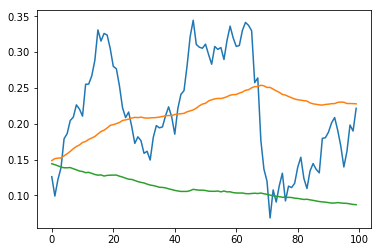

In [17]:
plt.plot(model_out.status)
plt.plot(model_out.income)
plt.plot(model_out.condition)

For testing purposes, here is a table giving each agent's x and y values at each step.

In [24]:
x_positions = model.datacollector.get_agent_vars_dataframe()

In [25]:
x_positions.head()

x  y
Step AgentID      
0    (0, 0)   8  4
     (0, 1)   6  1
     (0, 2)   8  5
     (0, 5)   7  2
     (0, 6)   4  1

# Effect of Homophily on segregation

Now, we can do a parameter sweep to see how segregation changes with homophily.

First, we create a function which takes a model instance and returns what fraction of agents are segregated -- that is, have no neighbors of the opposite type.

In [9]:
from mesa.batchrunner import BatchRunner

In [10]:
def get_segregation(model):
    '''
    Find the % of agents that only have neighbors of their same type.
    '''
    segregated_agents = 0
    for agent in model.schedule.agents:
        segregated = True
        for neighbor in model.grid.neighbor_iter(agent.pos):
            if neighbor.type != agent.type:
                segregated = False
                break
        if segregated:
            segregated_agents += 1
    return segregated_agents / model.schedule.get_agent_count()

Now, we set up the batch run, with a dictionary of fixed and changing parameters. Let's hold everything fixed except for Homophily.

In [11]:
fixed_params = {"height": 10, "width": 10, "density": 0.8, "minority_pc": 0.2} 
variable_parms = {"homophily": range(1,9)}

In [12]:
model_reporters = {"Segregated_Agents": get_segregation}

In [13]:
param_sweep = BatchRunner(SchellingModel, 
                          variable_parameters=variable_parms, fixed_parameters=fixed_params,
                          iterations=10, 
                          max_steps=200,
                          model_reporters=model_reporters)

In [14]:
param_sweep.run_all()

80it [00:02, 27.26it/s] 


In [15]:
df = param_sweep.get_model_vars_dataframe()

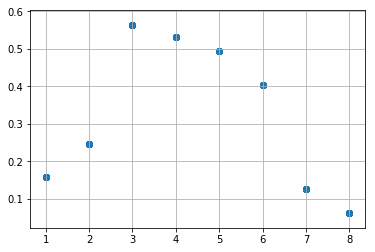

In [16]:
plt.scatter(df.homophily, df.Segregated_Agents)
plt.grid(True)